# 02477 Bayesian Machine Learning - Exercise 7

The purpose of this exercise is two-fold:

- to understand and become familiar with the Metropolis-Hastings algorithm
- and to learn to use posterior samples to compute predictions and posterior quantities of interest.

The exercise is divided into three parts

- Part 1: The Metropolis-Hastings algorithm for a 1D problem
- Part 2: The Metropolis-Hastings algorithm for a 2D problem
- Part 3: Metropolis-Hastings for a Bayesian Poisson regression model

In the first two parts, we will study the properties of the Metropolis-Hastings algorithm as well as its tuning parameters. In the part 3, we will use the algorithm to compute the posterior predictive distribution for a fully Bayesian Poisson regression model.

Note that to run this notebook, you'll also need the package called **tqdm** for plotting progress bars.

In [9]:
%matplotlib inline
import pylab as plt
import numpy as np
import seaborn as snb
from tqdm import tqdm

# distributions
from scipy.stats import expon
from scipy.stats import multivariate_normal as mvn
from scipy.stats import poisson

# for plotting and visualization
from exercise7 import plot_predictions
from exercise7 import eval_density_grid

# style stuff
snb.set_style('darkgrid')
snb.set(font_scale=1.5)

### Helper functions

We will need the following function for evaluating densities and log densities:

In [10]:
# Normal distribution
log_npdf = lambda x, m, v: -0.5*(x-m)**2/(v) - 0.5*np.log(2*np.pi*v)
npdf = lambda x, m, v: np.exp(log_npdf(x, m, v))

# Half-normal distribution
log_half_npdf = lambda x, m, v: np.log(2) -0.5*(x-m)**2/(v) - 0.5*np.log(2*np.pi*v)
half_npdf = lambda x, m, v: np.exp(log_half_npdf(x, m, v))

# Laplace distributions
log_laplace = lambda x: np.log(0.5) - np.abs(x)
laplace = lambda x: np.exp(log_laplace(x))


### Part1: The Metropolis-Hastings algorithm

The main idea of sampling-based methods is that we can compute any posterior quantity of interest if we can obtain a set of samples from the posterior. If $\mathbf{\theta}^{1}, \mathbf{\theta}^{2}, \dots, \mathbf{\theta}^{S} \sim p(\mathbf{\theta}|\mathbf{t})$, then we can approximate any posterior expectation using a **Monte Carlo estimate** as follows

\begin{align}
    \mathbb{E}_{\mathbf{\theta}|\mathbf{t}}\left[f(\mathbf{\theta})\right] \approx \frac{1}{S}\sum_{i=1}^S f(\mathbf{\theta}^i) 
\end{align}

In practice, it turns out to be very difficult to obtain **i.i.d** samples from general posterior distributions.  However, **Markov Chain Monte Carlo methods (MCMC)** provides a method for generating samples from almost any reasonable distribution, but the price is that the samples are often highly correlated, thus reducing the effective sample size.

The core idea of MCMC methods is to construct a Markov chain such that its stationary distribution will be equal to the distribution we want to sample from. Informally, we are creating a type of random walk that explores the parameter space of the target distribution in way where regions with high density are visited more frequently than areas with low density.

Today, we will work with the algorithm called the **Metropolis-Hastings** algorithm. Suppose our goal is to generate samples from a distribution over $\mathbf{\theta}$ (e.g. a prior distribution $p(\mathbf{\theta})$ or a posterior distribution $p(\mathbf{\theta}|\mathbf{t})$). Recall, we only need to be able to evaluate the target density up to constant. That is, if $p(\mathbf{\theta}) = \frac{1}{Z}\tilde{p}(\mathbf{\theta})$, then it is sufficient to be able to evaluate $\tilde{p}(\mathbf{\theta})$.

Every iteration of the MH algorithm proceeds as follows. Assume that the sample at iteration $k-1$ is $\theta^{k-1}$ and we want to compute the sample for iteration $k$. Then, the first step is to generate a new **candidate sample** $\theta^{\star}$ using a **proposal distribution** $q(\theta^{\star}|\theta^{k-1})$. The proposal distribution is chosen in a way such that it is easy to sample from it.

In this exercise, we will use Gaussian distributions as proposal distributions:

\begin{align*}
    q(\theta^{\star}|\theta^{k-1}) = \mathcal{N}(\theta^{\star}|\theta^{k-1}, \tau)
\end{align*}

or equivalently,

\begin{align*}
    \theta^{\star} = \theta^{k-1} + e_n, \quad\quad e_n \sim \mathcal{N}(0, \tau).
\end{align*}


That is, at iteration $k$, we generate the new candidate sample $\mathbf{\theta}^{\star}$ by taking sample for iteration $k-1$, i.e. $\mathbf{\theta}_{k-1}$, and adding a small amount of noise to it. The parameter $\tau$ is the variance of the proposal distribution and it controls how much noise we add to $\mathbf{\theta}^k$ when generating the candidate sample $\mathbf{\theta}^{\star}$. In other words, the parameter $\tau$ controls the **step-size** of the algorithm.
 
Once the candidate sample $\mathbf{\theta}^{\star}$ has been generated, the next step is to calculate the **acceptance probability** $A_k$ is given by

\begin{align*}
A_k = \min(1, r_k), \quad\quad\quad\text{where}\quad r_k = \frac{p(\mathbf{\theta}^{\star})  q(\mathbf{\theta}^{k-1}|\mathbf{\theta}^{\star}) }{p(\mathbf{\theta}^{k-1}) q(\mathbf{\theta}^{\star}|\mathbf{\theta}^{k-1})} \tag{1}.
\end{align*}

We now accept the new candidate sample $\mathbf{\theta}^{\star}$ with probability $A_k$. We can implement this by generating a sample $u_k \sim \mathcal{U}(0, 1)$ from a uniform distribution in the interval $(0, 1)$. If $u_k < A_k$, we accept the candidate $\mathbf{\theta}^{\star}$ and set $\mathbf{\theta}^{k} = \mathbf{\theta}^{\star}$. Otherwise, we reject new candidate and set $\mathbf{\theta}^{k} = \mathbf{\theta}^{k-1}$. That is

\begin{align*}
\mathbf{\theta}_k = \begin{cases}\mathbf{\theta}^{\star} & \text{if}\quad u_k < A_k\\ \tag{2}
\mathbf{\theta}^{k-1} & \text{otherwise}\end{cases}
\end{align*}

The Metropolis-Hastings algorithm proceeds like this until we have reached a predefined number of iterations. Recall, when working with probabilities on computers, it is numerically more stable to do as many calculations in the log-domain as possible and exponentiate as late as possible. Therefore, we should calculate $\log(r_k)$ and calculate $A_k$ as

\begin{align*}
A_k = \min(1, \exp[\log(r_k)]) \tag{3}
\end{align*}

The implementation of MH algorithm below is almost complete. Your first task is the understand the code and implement the missing pieces.


In [11]:
def metropolis(log_joint, num_params, tau, num_iter, theta_init=None, seed=None):    
    """ Runs a Metropolis-Hastings sampler 
    
        Arguments:
        log_joint:          function for evaluating the log joint distribution
        num_params:         number of parameters of the joint distribution (integer)
        tau:                variance of Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (integer)
        theta_init:         vector of initial parameters (np.array with shape (num_params) or None)        
        seed:               seed (integer or None)

        returns
        thetas              np.array with MCMC samples (np.array with shape (num_iter+1, num_params))
    """ 
    
    # prevent progress bar from causing issues
    if hasattr(tqdm,'_instances'):
        tqdm._instances.clear()
    
    if seed is not None:
        np.random.seed(seed)

    if theta_init is None:
        theta_init = np.zeros((num_params))
    
    # prepare lists 
    thetas = [theta_init]
    accepts = []
    log_p_theta = log_joint(theta_init)
    
    for k in tqdm(range(num_iter)):

        # get the last value for theta and generate new proposal candidate
        theta_cur = thetas[-1]
        theta_star = theta_cur + np.random.normal(0, tau, size=(num_params))
        
        # evaluate the log density for the candidate sample
        log_p_theta_star = log_joint(theta_star)

        # compute acceptance probability
        log_r = log_p_theta_star - log_p_theta
        A = min(1, np.exp(log_r))
        
        # accept new candidate with probability A
        if np.random.uniform() < A:
            theta_next = theta_star
            log_p_theta = log_p_theta_star
            accepts.append(1)
        else:
            theta_next = theta_cur
            accepts.append(0)

        thetas.append(theta_next)
        
    print('Acceptance ratio: %3.2f' % np.mean(accepts))
        
    thetas = np.stack(thetas)
    return thetas


# sanity check: estimate the mean and variance of a N(x|1,3) Gaussian distribution
thetas = metropolis(lambda x: log_npdf(x, 1., 3.), 1, 2., 10000, theta_init=np.array([0]), seed=0)

# compute mean and variance and relative errors
mean_thetas, var_thetas = np.mean(thetas), np.var(thetas)
rel_err_mean, rel_err_var = (mean_thetas - 1.)/1., (var_thetas - 3.)/3.

print('\nSanity check:')
print(f'Mean:\t{mean_thetas:3.2f} (rel. err: {rel_err_mean:3.2f})')
print(f'Var:\t{var_thetas:3.2f} (rel. err: {rel_err_var:3.2f})')

if np.abs(rel_err_mean) < 0.05 and np.abs(rel_err_var) < 0.05:
    print('The relative errors for the first two central moments are less than 5%. Everything looks ok.')
else:
    print('The relative errors for the first two central moments are larger than 5%. Something is likely wrong. Check your implementation')

100%|██████████| 10000/10000 [00:00<00:00, 56816.60it/s]

Acceptance ratio: 0.68

Sanity check:
Mean:	0.98 (rel. err: -0.02)
Var:	2.97 (rel. err: -0.01)
The relative errors for the first two central moments are less than 5%. Everything looks ok.


**Questions**

1.1) Complete the implementation of the Metropolis-Hastings algorithm above. See eq. (1), (2) and (3) above. Don't hesitate to ask for help if you are stuck in this question.


1.2) Why is it not necessary to include the proposal probabilities $q(\theta^{k-1}|\theta^{\star})$ and $q(\theta^{\star}|\theta^{k-1})$ when computing the acceptance probability for Gaussian proposals?


1.3) What is the resulting acceptance probability $A_k$ when the candidate sample $\theta^{\star}$ has higher density value than the previous sample $\theta^{k-1}$?


1.4) Use eq. (1) one above to argue that we don't need to be able to evaluate the joint density of the target distribution, but only the log joint density of up to a constant. That is, we only need to be evalute $\tilde{p}$. Why is this important in Bayesian modelling?


**Running the sampler** 

The code below runs the Metropolis-Hastings algorithm for the target distribution specified through the **log_joint** function. 

100%|██████████| 10000/10000 [00:00<00:00, 56679.17it/s]


Acceptance ratio: 0.85


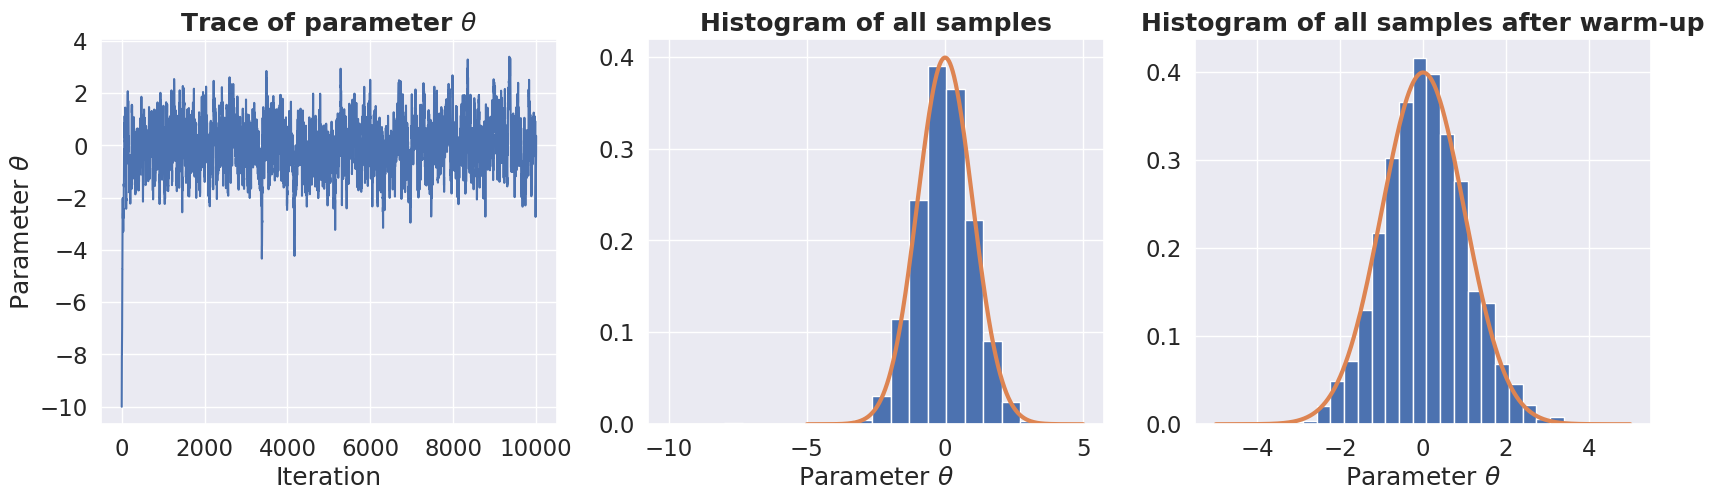

In [12]:
# specify number of parameters in the target distribution
num_params = 1

# specify the target distribution
log_joint = lambda x: log_npdf(x, 0, 1)
#log_joint = lambda x: log_laplace(x)
#log_joint = lambda x: np.log(0.5*laplace(x+2) + 0.5*laplace(x-2))

# specify the parameters of the MH algorithm
num_iterations = 10000
warm_up = int(0.5*num_iterations)
tau = 0.5

# run sampler
thetas = metropolis(log_joint, num_params, tau, num_iterations, theta_init=np.array([(-10)]), seed=0)

# plot resutls
xs = np.linspace(-5, 5, 1000)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].plot(thetas)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Parameter $\\theta$')
axes[0].set_title('Trace of parameter $\\theta$', fontweight='bold')

axes[1].hist(thetas, 20, density=True);
axes[1].plot(xs, np.exp(log_joint(xs)), linewidth=3)
axes[1].set_xlabel('Parameter $\\theta$')
axes[1].set_title('Histogram of all samples', fontweight='bold')

axes[2].hist(thetas[warm_up:], 20, density=True);
axes[2].plot(xs, np.exp(log_joint(xs)), linewidth=3)
axes[2].set_xlabel('Parameter $\\theta$');
axes[2].set_title('Histogram of all samples after warm-up', fontweight='bold');

**Questions**

1.5) Explain what you see in the three panels above.


1.6) Why do we need to discard the first proportion of samples (the warm-up phase)?


1.7) What happens to the acceptance ratio if you make the variance of the proposal distribution smaller, e.g. $\tau = 0.1$? How well does the resulting histogram of samples match the true target distribution?


1.8) What happens of you make the proposal variance larger, e.g. $\tau = 10$ or $\tau=500$? How well does the resulting histogram of samples match the true target distribution?

1.9) Using $\tau = 0.5$ and keeping warm up at 50%, how many iterations do you need before distribution of the samples resembles the target distribution (based on a visual comparison of the target density and the histogram of the samples)?

1.10) Experiment with the two other target functions specified above.



### Part 2: The metropolis-Hasting algorithm in 2D

In part 2, we will apply MH algorithm to generate samples from a bivariate normal distribution with correlation $\rho$. That is, the target density is

\begin{align*}
p(\mathbf{\theta}) = \mathcal{N}(\mathbf{\theta}|\mu, \Sigma),
\end{align*}

where $\mathbf{\theta} \in \mathbb{R}^2$, $\mathbf{\mu} = \begin{bmatrix}-4\\ 4\end{bmatrix}$, and $\mathbf{\Sigma} = \begin{bmatrix}1 & \rho \\ \rho & 1\end{bmatrix}$.

There are, of course, much more efficient ways to generate samples from multivarate normal distributions, but here we use the multivariate normal distribution to understand the properties of the MH algorithm.

100%|██████████| 10000/10000 [00:01<00:00, 7218.33it/s]


Acceptance ratio: 0.45
Mean and variance of samples for theta1: -4.02, 1.13
Mean and variance of samples for theta2: 3.96, 1.14


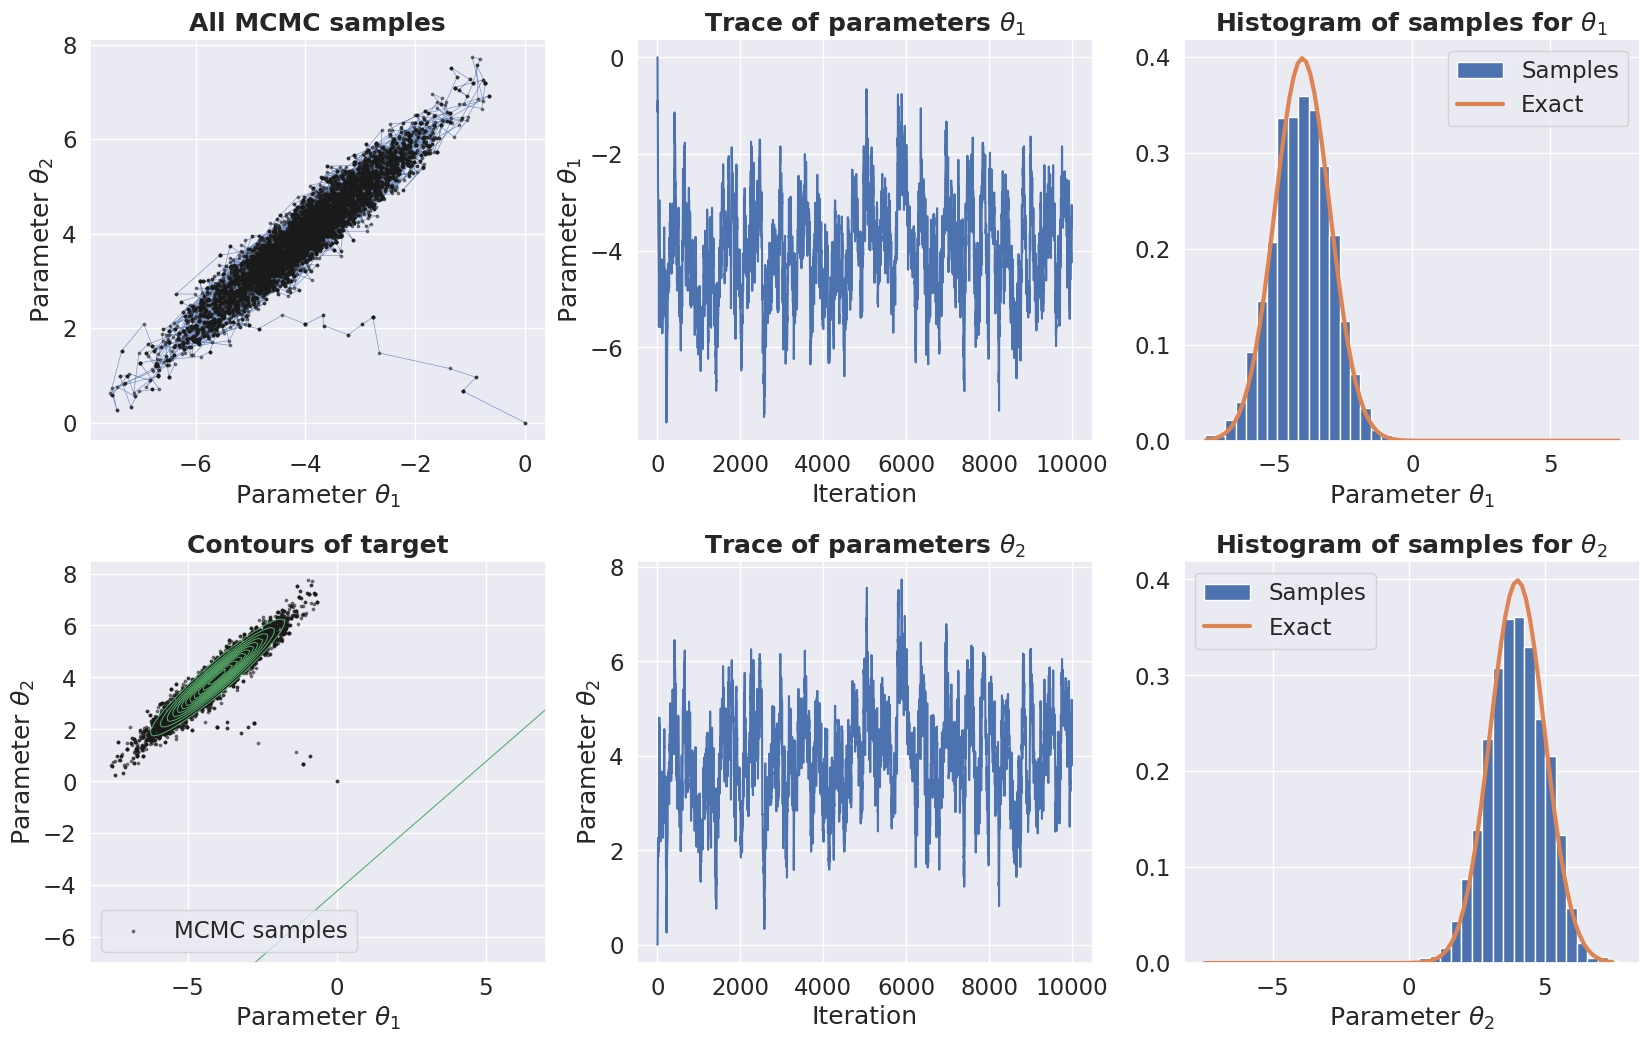

In [13]:
# specify target density
mu = np.array([-4, 4])                            # mean 
rho = 0.95                                        # correlation coef.
S = np.array([[1, rho], [rho, 1]])                # covariance matrix
log_joint = lambda x: mvn.logpdf(x, mu, S)        # target density

# specify number of parameters of the target density
num_params = 2

# sampler settings
num_iterations = 10000
warm_up = int(0.5*num_iterations)
tau = 0.5

# run sampler
thetas = metropolis(log_joint, num_params, tau, num_iterations, seed=0)

# discard samples from warm-up phase
#thetas = thetas[warm_up:, :]

# plot
xs = np.linspace(-7.5, 7.5, 100)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes[0, 0].plot(*thetas.T, lw=0.5, alpha=0.7, zorder=1)
axes[0, 0].scatter(*thetas.T, c="k", s=3, alpha=0.5, zorder=2)
axes[0, 0].set_xlabel('Parameter $\\theta_1$')
axes[0, 0].set_ylabel('Parameter $\\theta_2$')
axes[0, 0].set_title('All MCMC samples', fontweight='bold')


x_grid, log_density_grid = eval_density_grid(log_joint)
axes[1, 0].scatter(*thetas.T, c="k", s=3, alpha=0.5, label='MCMC samples')
axes[1, 0].contour(x_grid, x_grid, np.exp(log_density_grid), levels=15, linewidths=0.75, colors='g')
axes[1, 0].set_xlabel('Parameter $\\theta_1$')
axes[1, 0].set_ylabel('Parameter $\\theta_2$')
axes[1, 0].set_title('Contours of target', fontweight='bold')
axes[1, 0].legend()

for i in range(2):
    axes[i, 1].plot(thetas[:, i])
    axes[i, 1].set_title('Trace of parameters $\\theta_{%d}$' % (i+1), fontweight='bold')
    axes[i, 1].set_xlabel('Iteration')
    axes[i, 1].set_ylabel('Parameter $\\theta_{%d}$' % (i+1))
    
    axes[i, 2].hist(thetas[:, i], 20, density=True, label='Samples')
    axes[i, 2].set_xlabel('Parameter $\\theta_{%d}$' % (i+1))
    axes[i, 2].plot(xs, npdf(xs, mu[i], S[i,i]), linewidth=3, label='Exact')
    axes[i, 2].set_title('Histogram of samples for $\\theta_{%d}$' % (i+1), fontweight='bold')
    axes[i, 2].legend()
    
    print('Mean and variance of samples for theta%d: %3.2f, %3.2f' % (i+1, np.mean(thetas[:, i]), np.var(thetas[:, i])) )
    
fig.subplots_adjust(hspace=0.3)


Experiment with the code above to answer the following questions:

**Questions**

2.1) Experiment with the number of iterations. How many iterations do you need before the sample mean and variance are equal to the true values (up to, say, 5%-10% relative error)?

2.2) Repeat the experiment with and without discarding the samples from the warm-up phase. What changes do you see?

2.3) What happens to the acceptance ratio if you increase the correlation in the target density to, say, $\rho = 0.7$, $\rho=0.9$, $\rho=0.95$ or $\rho=0.99$? What happens to the accuracy of the moments?


### Part 3: MCMC for Bayesian Poisson regression

Now we will apply the Metropolis-Hastings algorithm to Bayesian Poisson regression (discussed in lecture 5). As a case study, we will use a small data set from a study on mortality (Broffiti, 1988), where the authors looked at the mortality rates as a function of age. 

Let's look at the data.

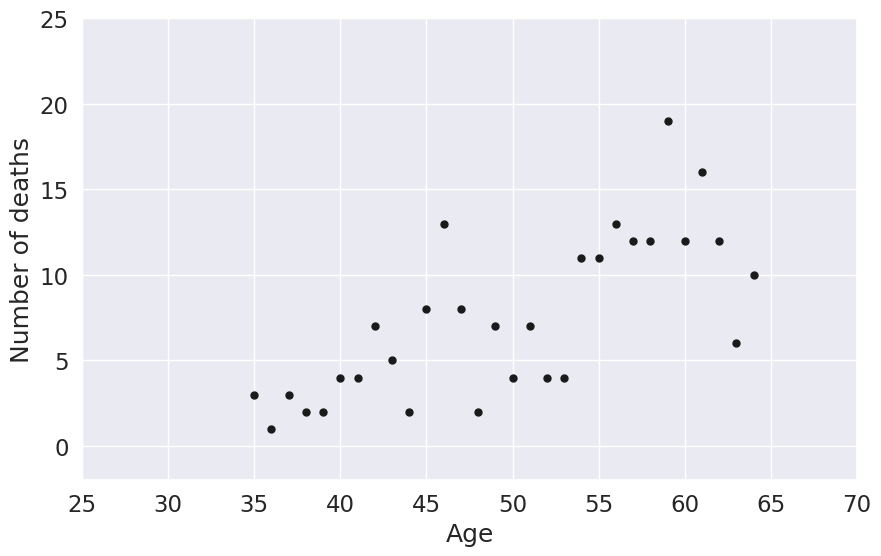

In [14]:
###################################################
# Raw data
###################################################

# The input covariate is age
age = np.arange(35, 65).astype(np.float64)

# The output is the number of deaths in the study popular for each age
deaths = np.array([3, 1, 3, 2, 2, 4, 4, 7, 5, 2, 8, 13, 8, 2, 7, 4, 7, 4, 4, 11, 11, 13, 12, 12, 19, 12, 16, 12, 6, 10]).astype(np.float64)

# number of data points
N = len(deaths)

# Let's standardize the input covariate and prepare 
m_age = np.mean(age)
s_age = np.std(age)
standardize = lambda x: (x-m_age)/s_age

# prep data
X = standardize(age)
X = X[:, None]
t = age[:, None]

# Define input points for prediction
age_pred = np.linspace(25, 70, 100)
Xp = standardize(age_pred)

# Let's set-up the design matrix for the training data and the inputs for predictions
design_matrix = lambda x: np.column_stack((np.ones(len(x)), x))
X_train = design_matrix(X)
X_pred = design_matrix(Xp)

# Plotting
def plot_data(ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
    ax.plot(age, deaths, 'k.', markersize=10)
    ax.set_xlabel('Age')
    ax.set_ylabel('Number of deaths')
    
    ax.set_xlim((25, 70))
    ax.set_ylim((-2, 25))


plot_data()

We will a use **generalized linear model** to model this dataset. Since the target variable $t_n$ is **count data**, i.e., $t_n \in \left\lbrace 0, 1, 2, \dots \right\rbrace$, we will use a Poisson likelihood to model the data. If you don't recall what the Poisson distribution looks like, then the Wikipedia page is useful: https://en.wikipedia.org/wiki/Poisson_distribution. 

The likelihood of a single data point is given by

\begin{align*}
t_n|\mu_n \sim \text{Poisson}(\mu_n),
\end{align*}

where $\mu_n > 0$ is the mean parameter for the Poisson distribution, i.e., $\mathbb{E}_{t_n|\mu_n}\left[t_n\right] = \mu_n$.

Since count data are non-negative, we will use the **log link function** 

\begin{align*}
\log(\mu_n) = y_n \quad\quad \iff \quad \quad \mu_n = \exp(y_n),
\end{align*}

where $y_n = y(\mathbf{x}_n)$ is a linear model with parameters $\mathbf{w} \in \mathbb{R}^2$

\begin{align*}
y(\mathbf{x}) = \mathbf{w}^T \mathbf{x}_n = w_0 + w_1\cdot\text{age}.
\end{align*}

The model has two parameters: an intercept $w_0$ and a slope $w_1$. To perform Bayesian inference,  we will impose a Gaussian prior distribution on both for regularization

\begin{align*}
p(\mathbf{w}|\kappa^2) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \kappa^2 \mathbf{I}),
\end{align*}

where $\kappa^2 > 0$ is the variance of the prior. Earlier in the course, we estimated **hyperparameters** like $\kappa^2$ by optimizing the marginal likelihood. However, since we are dealing with a rather small dataset, we will be fully Bayesian and impose a **hyperprior** distribution on $\kappa^2$. That is, we consider $\kappa^2$ a random variable and impose a prior distribution on it. 

Specifically, we will use a **half-normal distribution** as prior for $\kappa^2$:
\begin{align*}
\kappa^2 \sim \mathcal{N}_+(0, 1)
\end{align*}

The half-normal distribution is just the "positive-part" of a standard normal distribution (https://en.wikipedia.org/wiki/Half-normal_distribution) and it serves to prevent to prior variance of $\mathbf{w}$ from becoming too large such that we risk overfitting.

To summarize, the full probabilistic model looks as follows:

\begin{align*}
t_n|\mu_n &\sim \text{Poisson}(\mu_n),\\
\mu_n &= \exp(y_n)\\
y_n &= \mathbf{w}^T \mathbf{x}_n\\
\mathbf{w}|\kappa^2 &= \mathcal{N}(0, \kappa^2\mathbf{I})\\
\kappa^2 &\sim \mathcal{N}_+(0, 1)
\end{align*}


One way to understand this model is to consider the "generative story" (via ancestral sampling):
1. Nature samples a value for $\kappa^2 \sim \mathcal{N}_+(0, 1)$.
2. Using that specific value of $\kappa^2$, nature picks a set of weights $\mathbf{w}|\kappa^2 = \mathcal{N}(0, \kappa^2\mathbf{I})$.
3. Using those specific weights, nature computes the mean values for all observations $\mu_n = \exp(\mathbf{w}^T \mathbf{x}_n)$.
4. Finally, nature picks a value for each observation $t_n$ by sampling from $t_n|\mu_n \sim \text{Poisson}(\mu_n)$.

The joint density of the model is given by
\begin{align*}
p(\mathbf{t}, \mathbf{w}, \kappa^2) = \prod_{n=1}^N p(t_n|\mathbf{w})p(\mathbf{w}|\kappa^2)p(\kappa^2),
\end{align*}

where we have used $t_n|\mathbf{w} \sim \text{Poisson}(\exp(\mathbf{w}^T \mathbf{x}_n))$.


The parameter $\kappa^2 > 0$ is a positive parameter and to avoid problems with our sampler, we will reparametrize $\kappa^2$ as $\eta = \log(\kappa^2) \in \mathbb{R}$. Otherwise, we would risk that the Metropolis-Hastings algorithm would take a step, where $\kappa^2$ would become negative. This **change-of-variables** introduces a correction term into the joint density:

\begin{align*}
p(\mathbf{t}, \mathbf{w}, \eta) = \prod_{n=1}^N p(t_n|\mathbf{w})p(\mathbf{w}|\kappa^2)p(\exp(\eta)) \exp(\eta)
\end{align*}

accounting for the change $\kappa^2 = \exp(\eta)$. 

Finally, we can implement a function for the log joint density of the model.




In [15]:
num_params = 3

def log_joint_poisson(theta):
    """ Computes the log joint distribution for the Poisson regression model.
    The argument theta is an np.array of shape (3), where the first two elements are the weights w and the last element is log(kappa2).
    It returns the log joint distribution evaluated at theta (includes change-of-variable term).
    """
    
    # theta is three-dimensional, the first two entries represent the weights and the last represents eta = log(kappa^2)
    w = theta[:2]
    kappa2 = np.exp(theta[2])
    
    # log hyperprior and change-of-variable term
    log_hyperprior = log_half_npdf(kappa2, 0, 1) + theta[2]
    
    # log prior
    log_prior = np.sum(log_npdf(w, 0, kappa2))
    
    # log likelihood
    y = X_train@w
    mu = np.exp(y)
    log_likelihood = np.sum(poisson.logpmf(deaths, mu))
    
    return log_likelihood + log_prior + log_hyperprior
    
num_iter = 20000
warm_up = int(0.5*num_iter)

thetas_poisson = metropolis(log_joint_poisson, num_params, 0.3, num_iter=num_iter)

# get rid of warm-up samples
#thetas_poisson = thetas_poisson[warm_up:, :]

100%|██████████| 20000/20000 [00:01<00:00, 11061.38it/s]


Acceptance ratio: 0.08


***Questions***

3.1) Complete the implementation of the function *log_joint_poisson* above.

*Hint*: The function *poisson.logpmf* will be useful.

Let's extract the MCMC samples and plot the trace for each parameter

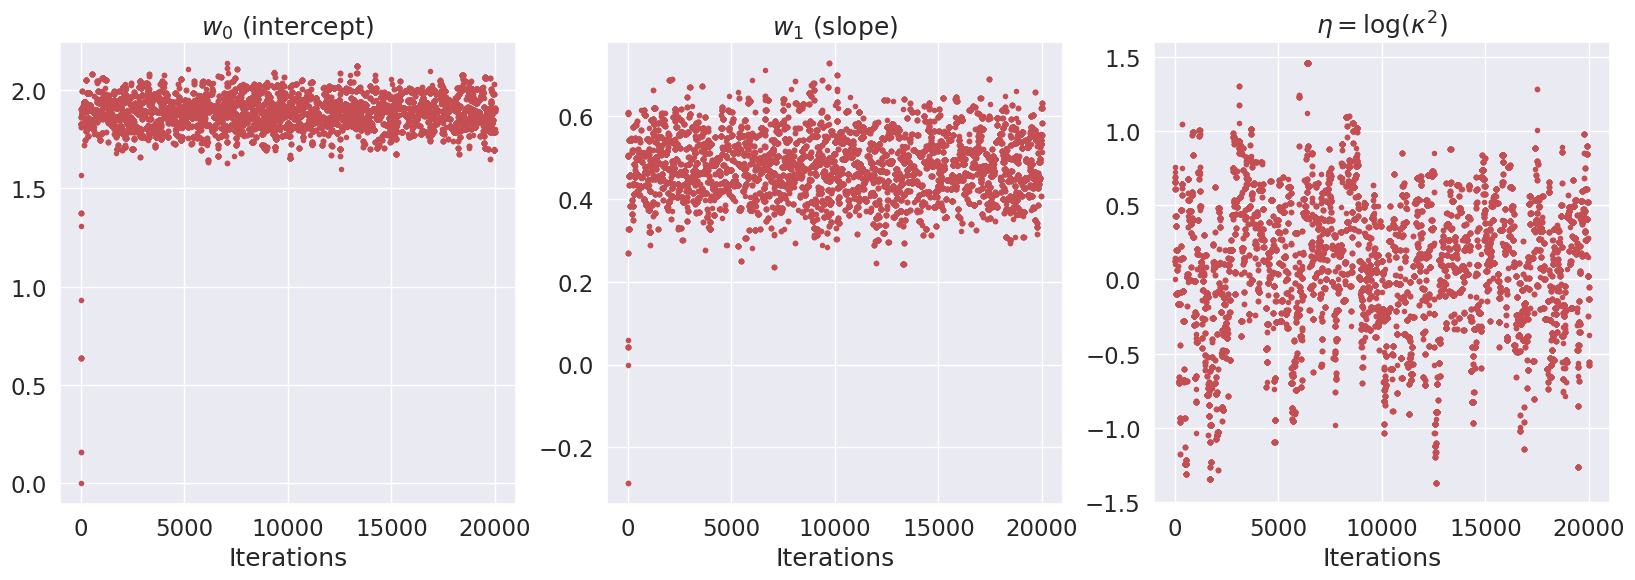

In [16]:
# extract
w_samples = thetas_poisson[:, :2]
eta_samples = thetas_poisson[:, 2]

# transform
kappa2_samples = np.exp(eta_samples)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].plot(w_samples[:, 0], 'r.')
axes[0].set_title('$w_0$ (intercept)')

axes[1].plot(w_samples[:, 1], 'r.')
axes[1].set_title('$w_1$ (slope)')

axes[2].plot(eta_samples, 'r.')
axes[2].set_title('$\\eta = \log(\kappa^2)$')

for i in range(3):
    axes[i].set_xlabel('Iterations')

**Questions**

3.2) Inspect the trace for each parameter. Does it appear to have converged?


3.3) Do you see the effect of the initial point?


3.4) Uncomment the line that removes the warm-up samples above and re-do the plots



### Let's compare samples from the prior and the posterior

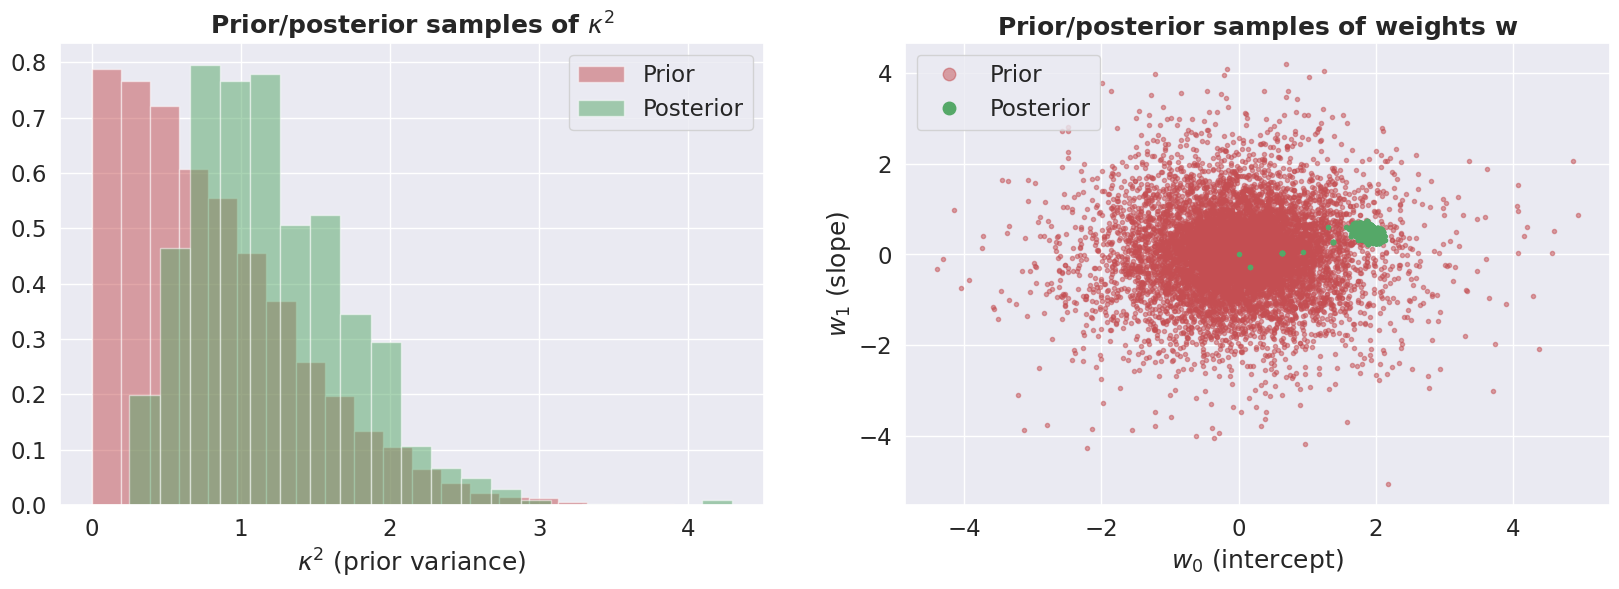

In [17]:
# number of samples
S = 10000

# generate prior samples for kappa2 (w)
kappa2_prior_samples = np.abs(np.random.normal(0, 1, size=S))

# generate samples from w|kappa2
w_prior_samples = np.random.normal(0, np.sqrt(kappa2_prior_samples)[:, None], size=(S, 2))


fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# samples of kappa^2
axes[0].hist(kappa2_prior_samples, 20, density=True, color='r', alpha=0.5, label='Prior')
axes[0].hist(kappa2_samples, 20, density=True, color='g', alpha=0.5, label='Posterior',  )

axes[0].set_xlabel('$\kappa^2$ (prior variance)')
axes[0].set_title('Prior/posterior samples of $\kappa^2$', fontweight='bold')
axes[0].legend()

# samples of w
axes[1].plot(w_prior_samples[:, 0], w_prior_samples[:, 1], 'r.', alpha=0.5, label='Prior')
axes[1].plot(w_samples[:, 0], w_samples[:, 1], 'g.', label='Posterior')
axes[1].legend(loc='upper left', markerscale=3)

axes[1].set_xlabel('$w_0$ (intercept)')
axes[1].set_ylabel('$w_1$ (slope)')
axes[1].set_title('Prior/posterior samples of weights $\mathbf{w}$', fontweight='bold');

**Questions**

3.5) Inspect the two plots above and explain what you see. 

3.6) What is the  probability of the event $w_1 > 0$, i.e. the probability of the slope being positive, under both the prior and the posterior?




Recall, we can easily calculate such probabilities using samples:

In [18]:
# solution 3.6
print('Probability of the event: w1 > 0')
print(50*'-')
print('Prior probability:\t%3.2f' % np.mean(w_prior_samples[:, 1] > 0))
print('Posterior probability:\t%3.2f' % np.mean(w_samples[:, 1] > 0))

Probability of the event: w1 > 0
--------------------------------------------------
Prior probability:	0.51
Posterior probability:	1.00


That is, we are quite certain that increased age is associated with increased mortality (not very surprising).

### Making predictions

Now that we have samples for the posterior over the weights, $p(\mathbf{w} | \mathbf{t})$, we can use it to compute and plot the predictive distribution for our Bayesian Poisson regression model using MC sampling.

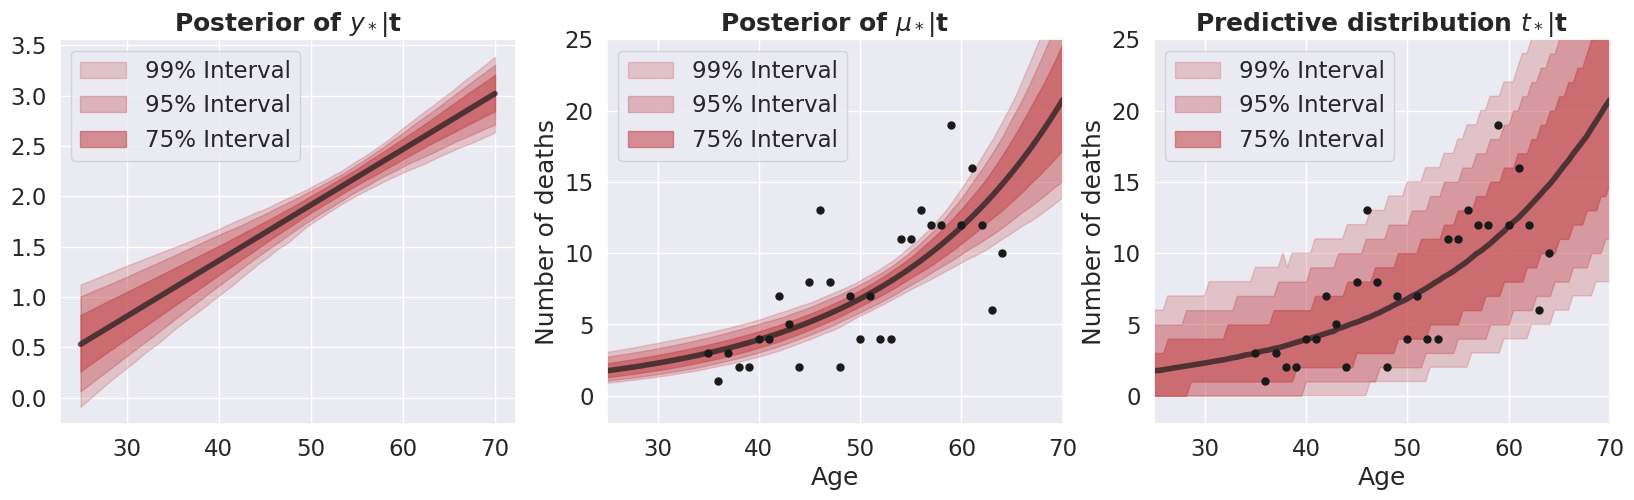

In [19]:
# making predictions by mapping the posterior samples of (w, kappa^2) through the model
y_samples = X_pred@w_samples.T
mu_samples = np.exp(y_samples)
t_samples = np.random.poisson(mu_samples)

# plot
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plot_predictions(axes[0], age_pred, y_samples.T, num_samples=0, legend=True, title='Posterior of $y_*|\mathbf{t}$')
plot_predictions(axes[1], age_pred, mu_samples.T, num_samples=0, legend=True, title='Posterior of $\mu_*|\mathbf{t}$')
plot_predictions(axes[2], age_pred, t_samples.T, num_samples=0, legend=True, title='Predictive distribution $t_*|\mathbf{t}$')
plot_data(axes[1])
plot_data(axes[2])

**Questions**

3.7) Compute and visualize the posterior distributions for $y_*, \mu_*, t_*$ for $\text{age} = 75$

3.8) Report the mean and standard deviation of $p(t_*|\mathbf{t})$ for $\text{age} = 75$

3.9) Compute the posterior probability of the event  $\text{num. deaths} > 40$ for $\text{age} = 75$

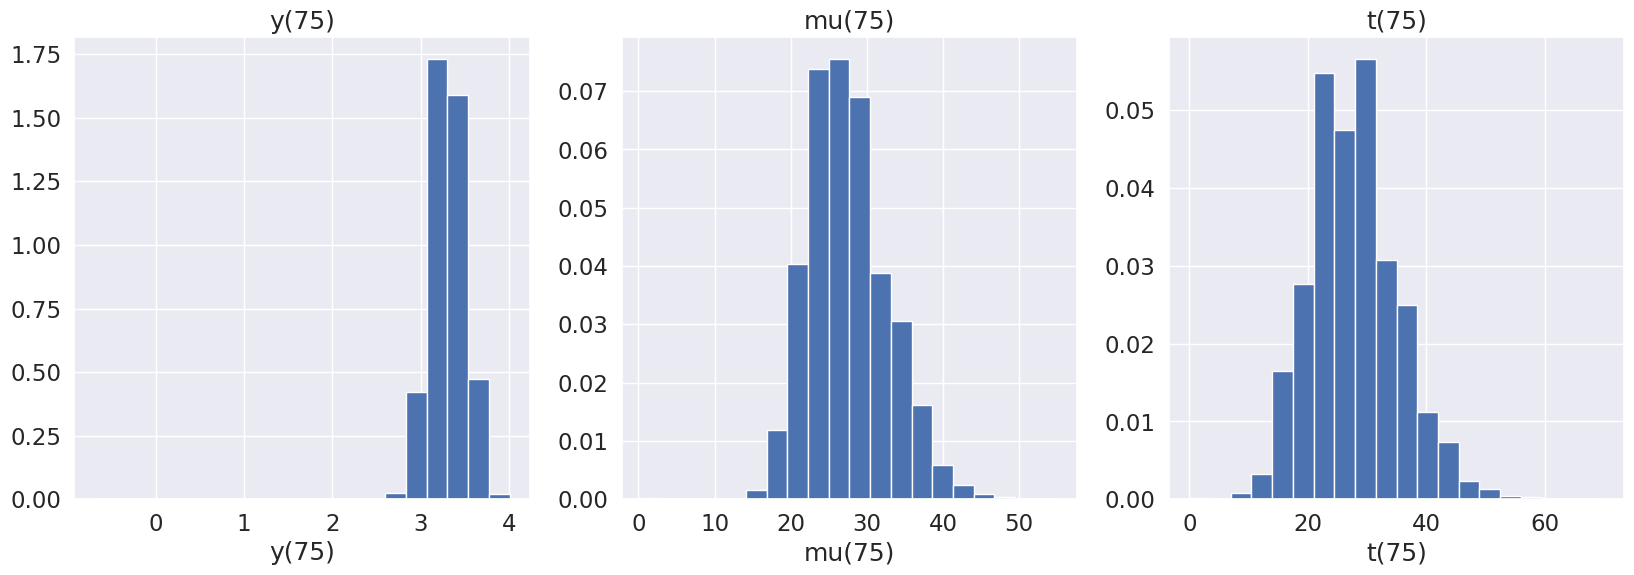

In [20]:
### solution for 3.7
Xp75 = np.array([1, standardize(75)])
y_75 = Xp75@w_samples.T
mu_75 = np.exp(y_75)
t_75 = np.random.poisson(mu_75)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (name, values) in enumerate(zip(['y(75)', 'mu(75)', 't(75)'], [y_75, mu_75, t_75])):
    axes[i].hist(values, 20, density=True)
    axes[i].set_xlabel(name)
    axes[i].set_title(name)
    

In [21]:
# solution for 3.8
print('Posterior mean and std. dev: %3.2f and %3.2f' % (np.mean(t_75), np.std(t_75)))

Posterior mean and std. dev: 27.55 and 7.44


In [22]:
# solution for 3.9
print('Probability that num. of deaths > 40 for age = 75: %3.2f' % np.mean(t_75 > 40))

Probability that num. of deaths > 40 for age = 75: 0.05
